In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import FIGURE_DIR, ensure_dir
from avgn.utils.general import save_fig

In [5]:
DATASET_ID = 'buckeye'

In [6]:
window_loc = DATA_DIR / 'umap_windows/buckeye/way_say_day_12.pickle'

In [7]:
words_df = pd.read_pickle(window_loc)

In [8]:
words_df[:3]

start_time    end_time word   phones            phone_start_times  \
445  236.236188  236.352105  say  [s, eh]  [0.0, 0.060875000000010004]   
492  250.321120  250.586825  say  [s, ey]    [0.0, 0.1448169999999891]   
610  293.978018  294.234862  say  [s, ey]   [0.0, 0.13373199999995222]   

                                 phone_end_times  utterance_number  \
445  [0.060875000000010004, 0.11591699999999605]                74   
492    [0.1448169999999891, 0.26570499999999697]                17   
610   [0.13373199999995222, 0.25684400000000096]                22   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
445                     31           31  s25      0   o   f  s2501b  16000   
492                     10           10  s25      0   o   f  s2501b  16000   
610                      9            9  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
445  [[23, 20, 13, 10, 8, 10, 11, 14, 17, 29, 36, 4...   
492  [[10, 9, 6, 2, 0, 1, 3, 4, 3, 1, 0, 0, 0, 0, 3...   
610  [[174, 170, 157, 133, 95, 53, 30, 23, 20, 17, ...   

                                               windows  
445  [[[23, 33, 18, 28, 2, 17, 1, 0, 7, 9, 7, 3, 4,...  
492  [[[10, 2, 26, 62, 29, 6, 9, 0, 0, 0, 0, 0, 4, ...  
610  [[[174, 118, 112, 135, 116, 80, 47, 74, 76, 83...

In [9]:
word_counts = pd.DataFrame({i:[sum(words_df.word == i)] for i in words_df.word.unique()})
word_counts

say  day  way
0  564  228  471

In [10]:
#words_df = pd.concat([words_df[words_df.word == word][:int(word_counts.T.min())] for word in words_df.word.unique()])

In [11]:
len(words_df)

1263

In [12]:
word_group = '_'.join(words_df.word.unique())
word_group

'say_day_way'

In [13]:
FIG_SAVE_LOC = FIGURE_DIR/'umap_seqs' / DATASET_ID / word_group
ensure_dir(FIG_SAVE_LOC)

In [14]:
pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()})

s25  s08  s24  s40  s15  s17  s13  s16  s26  s35  ...  s32  s01  s14  s29  \
0   39   34   25   48   27   18   66   89   27   27  ...   29   20   39   45   

   s31  s28  s39  s04  s21  s33  
0   10   15   16   15   19   14  

[1 rows x 40 columns]

In [15]:
np.unique(np.concatenate(words_df.phones.values))

array(['ah', 'ay', 'd', 'dh', 'dx', 'eh', 'ey', 'ih', 'iy', 'm', 'n', 's',
       't', 'th', 'tq', 'w', 'y', 'z'], dtype='<U2')

In [16]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [17]:
n_windows[:5]

[27, 65, 63, 129, 51]

In [18]:
# get beginnings and endings of each sequence
onsets = [0]
offsets = [n_windows[0]-1]
for wd in n_windows[1:]:
    onsets.append(offsets[-1]+1)
    offsets.append(onsets[-1]+wd-1)
onsets[:5], offsets[:5], len(onsets), len(offsets)

([0, 27, 92, 155, 284], [26, 91, 154, 283, 334], 1263, 1263)

In [19]:
{i:sum(words == i) for i in np.unique(words)}

{'day': 15601, 'say': 34407, 'way': 25376}

In [20]:
words[:10]

array(['say', 'say', 'say', 'say', 'say', 'say', 'say', 'say', 'say',
       'say'], dtype='<U3')

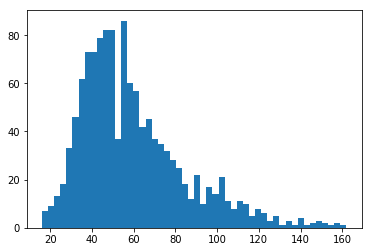

In [21]:
plt.hist(n_windows, bins=50);

In [22]:
rate = 16000

In [23]:
windows = np.vstack(list(words_df.windows))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(75384, 3, 32)
(75384, 96)


In [24]:
cuml_umap = cumlUMAP(min_dist = 0.25)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


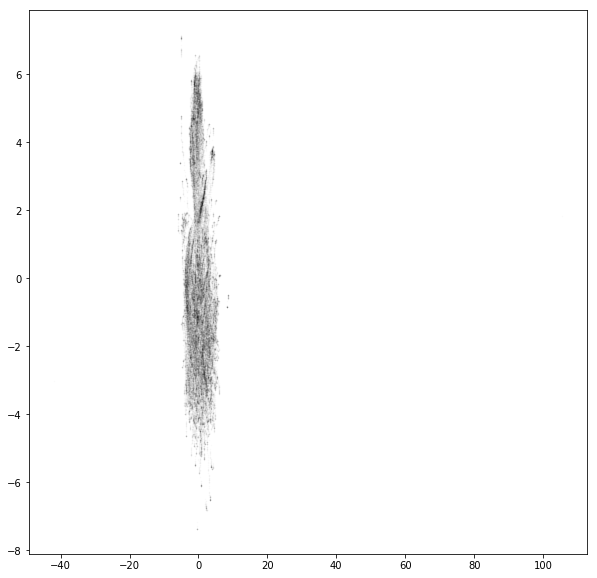

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color='k')
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])

### plot over time

In [26]:
savefig = False

In [27]:
from avgn.visualization.projections import colorline

In [28]:
xlims = [-6,6]
ylims = [-6,6]

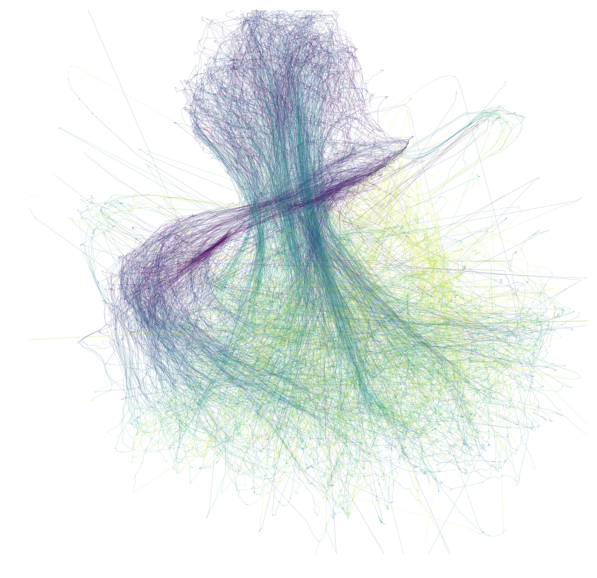

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)


for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.1, s = 1, color=cols)
    colorline(window_z[:,0], window_z[:,1], alpha = 0.1, ax = ax, cmap=plt.cm.viridis, linewidth=1)
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'trajectory', save_png=True)

### plot by word

In [30]:
len(np.unique(words))

3

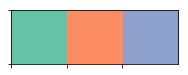

In [31]:
pal = sns.color_palette('Set2', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [32]:
word_pal

{'day': (0.4, 0.7607843137254902, 0.6470588235294118),
 'say': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'way': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}

In [33]:
cols = [word_pal[i] for i in words]

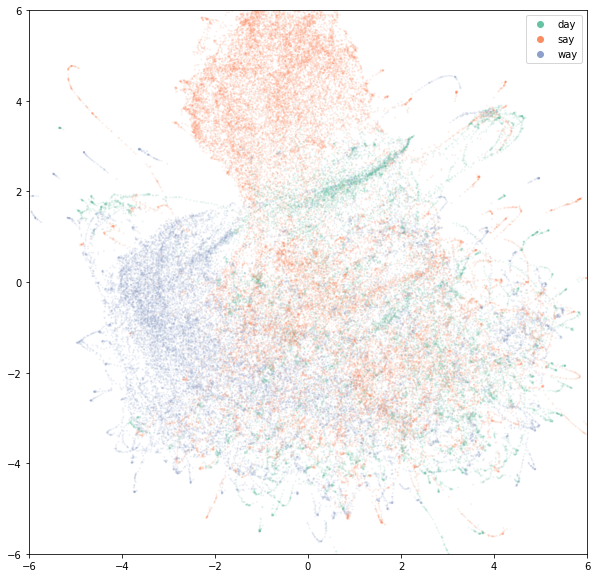

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color=cols)
ax.set_xlim(xlims);
ax.set_ylim(ylims);

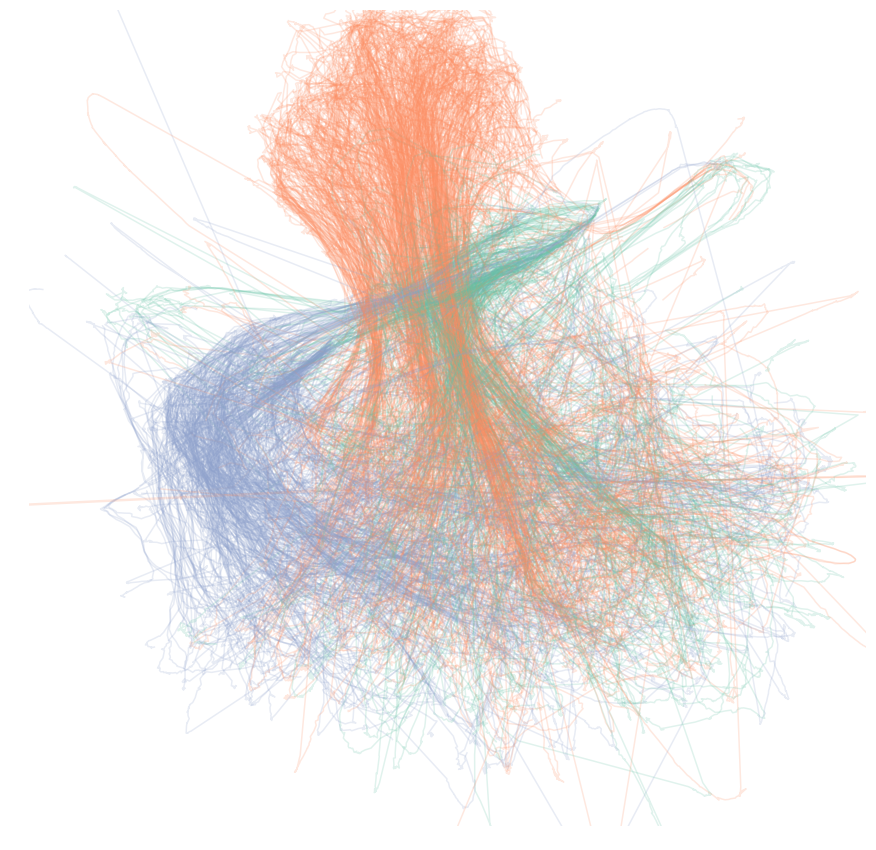

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color=word_pal[words_df.word.values[oi]])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'words_trajectory', save_png=True)

### plot the average over each vector for word

In [36]:
from scipy.interpolate import interp1d

In [37]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
word_embedding_list = []
for oi, (word, on, off) in enumerate(tqdm(zip(words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)

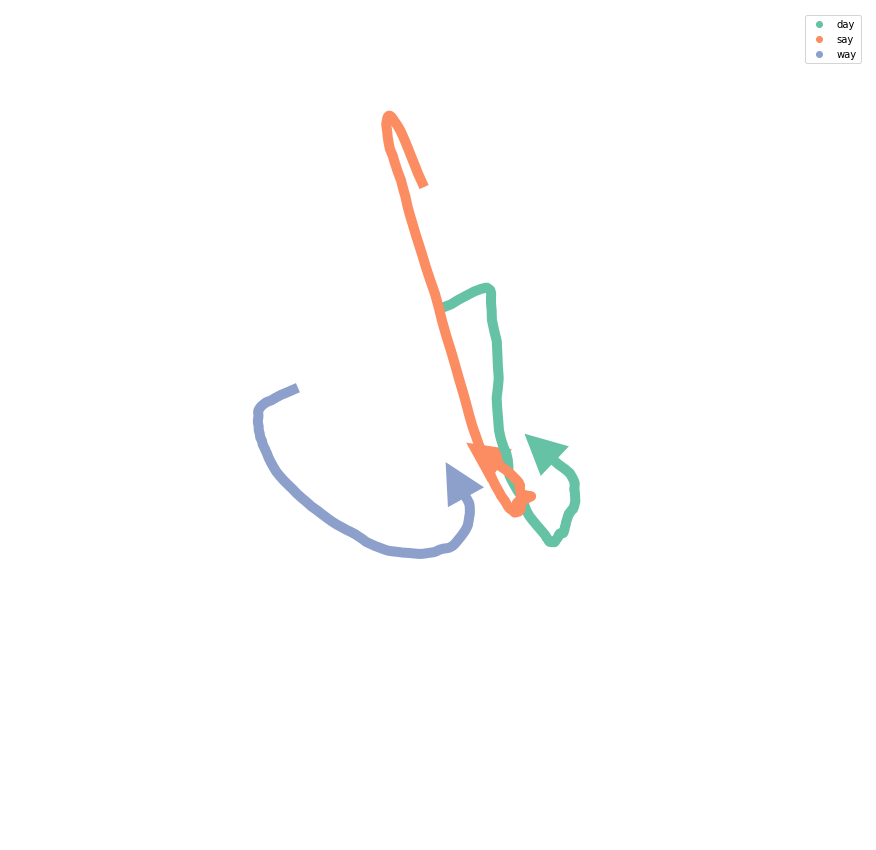

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)


for word in np.unique(word_list):
    mean_embedding = np.mean(word_embedding_list[word_list == word], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')
if savefig:  save_fig(FIG_SAVE_LOC / 'words_vector', save_png=True, save_svg=True)

### color by phonemes

In [39]:
#make a list of phones, onsets, and offsets for each phone
# for each word, for each phone, get start time and end time in frames

In [40]:
window_length_ms = 4
hop_length_ms = 4
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

1

In [41]:
phones = []
phone_onsets = []
phone_offsets = []
words_phones = []
for wdsi, (idx, row) in tqdm(enumerate(words_df.iterrows()), total= len(words_df)):
    cur_windows = len(row.windows)
    phone_start_frame = [0]
    phone_end_frame = []
    for pi, (phone, pst, pet) in enumerate(zip(row.phones, row.phone_start_times, row.phone_end_times)):
        phone_end_frame.append(int(pet / (window_length_ms / 1000)))
        if pi < len(row.phones)-1:
            phone_start_frame.append(phone_end_frame[-1]+1)
    
    phone_onsets.append(np.array(phone_start_frame) + np.sum([0] + n_windows[:wdsi]))
    phone_offsets.append(np.array(phone_end_frame) + np.sum([0] + n_windows[:wdsi]))
    phones.append(row.phones)
    words_phones.append(np.repeat(row.word, len(row.phones)))
phones = np.concatenate(phones)    
phone_onsets = np.concatenate(phone_onsets)
phone_offsets = np.concatenate(phone_offsets)
words_phones = np.concatenate(words_phones)

In [42]:
print(phones[:15], phone_onsets[:15], phone_offsets[:15])

['s' 'eh' 's' 'ey' 's' 'ey' 'd' 'ey' 'w' 'ey' 'd' 'ey' 'w' 'ey' 'w'] [  0  16  27  64  92 126 155 171 284 303 335 346 416 426 449] [ 15  28  63  93 125 156 170 285 302 336 345 417 425 450 464]


In [43]:
common_phones = pd.DataFrame({i:[sum(phones == i)] for i in np.unique(phones)}).T.sort_values(by=0, ascending=False)[:4].T
common_phones

ey    s    w    d
0  1205  561  471  220

In [44]:
common_phones.columns

Index(['ey', 's', 'w', 'd'], dtype='object')

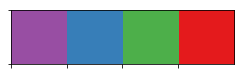

In [45]:
pal = np.random.permutation(sns.color_palette('Set1', len(common_phones.columns)))
sns.palplot(pal)
phone_pal = {word:pal[wordi] for wordi, word in enumerate(common_phones.columns)}

In [46]:
phone_pal[phone]

array([0.59607843, 0.30588235, 0.63921569])

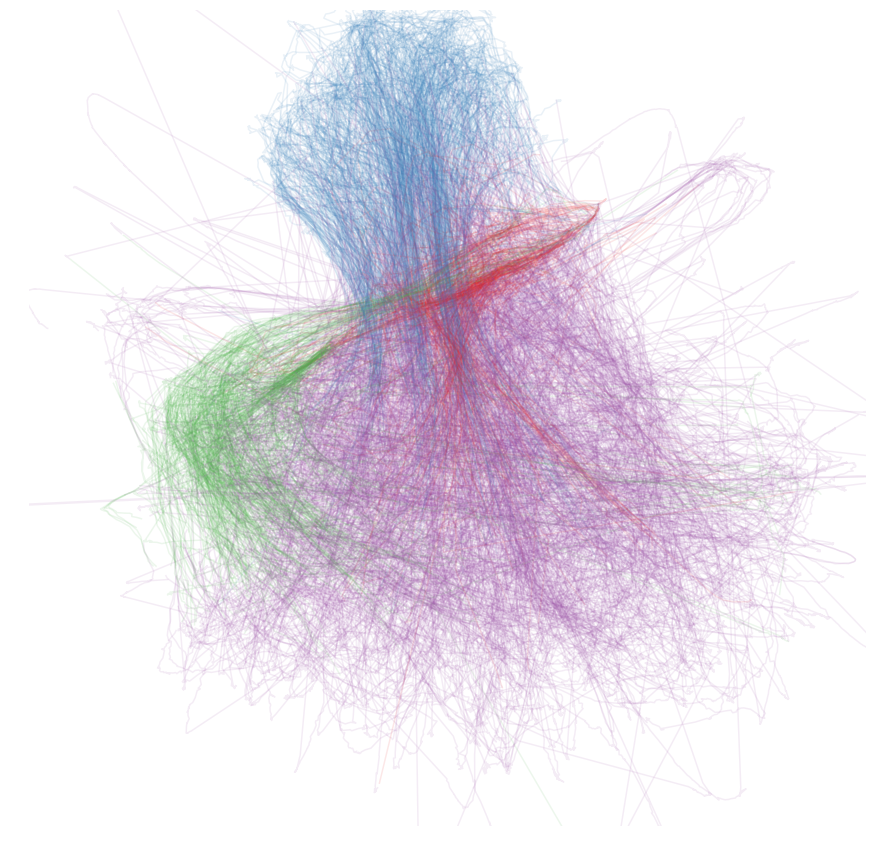

In [47]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
#ax.legend(markers, phone_pal.keys(), numpoints=1)

for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=phone_pal[phone])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_trajectory', save_png=True, save_svg=False)

### plot the average vector for each phone

In [48]:
len(np.linspace(0,1, len(window_z)))

28

In [49]:
np.shape(interp_window_z)

(100, 2)

In [50]:
#fig, ax = plt.subplots(figsize=(5,5))
phone_list = []
embedding_list = []
for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    
    phone_list.append(phone)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)

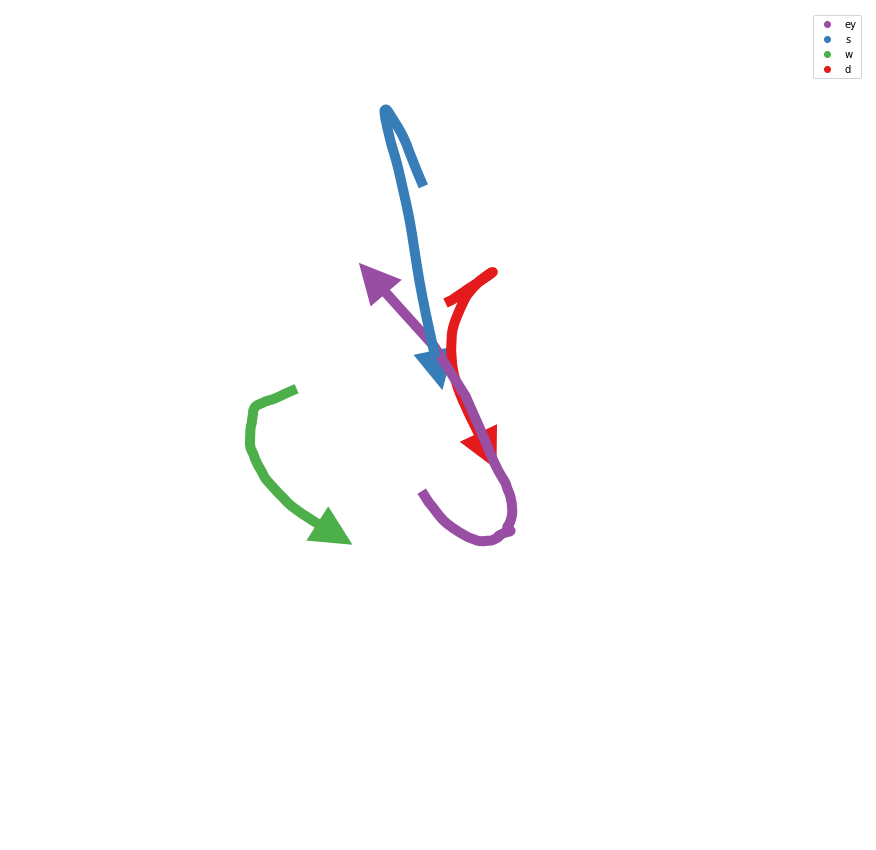

In [51]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### plot phone by context

In [52]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
phone_list = []
embedding_list = []
for oi, (wp, phone, on, off) in enumerate(tqdm(zip(words_phones, phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    
    phone_list.append(phone)
    word_list.append(wp)
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)
word_list = np.array(word_list)

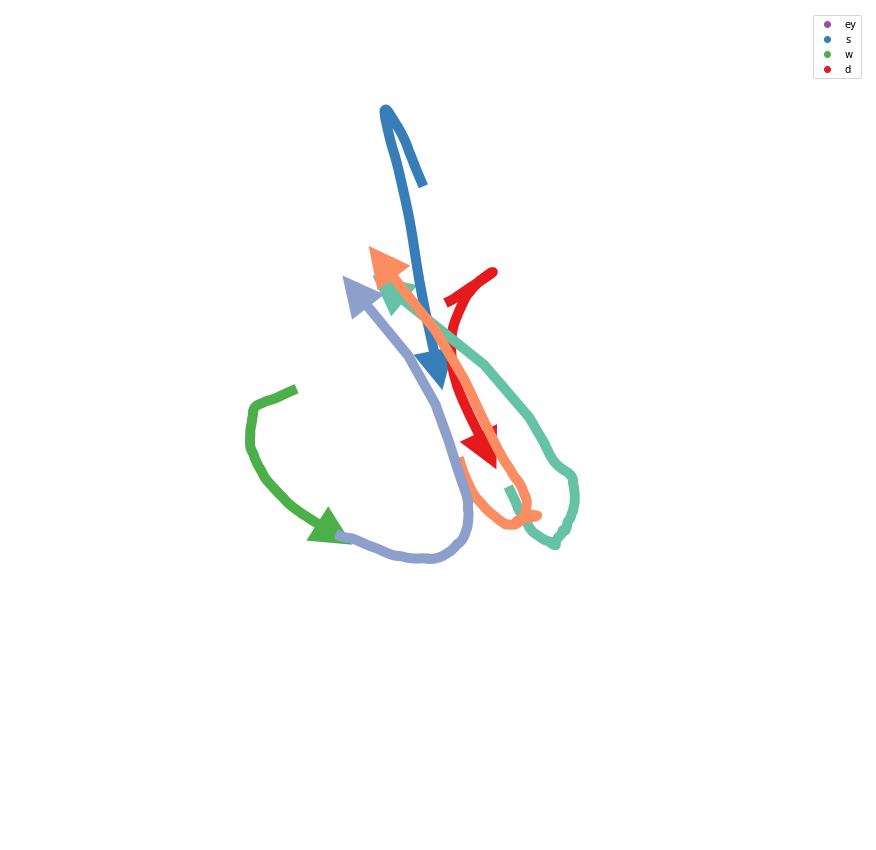

In [53]:
phone_of_interest = 'ey'
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    if phone == phone_of_interest:
        continue
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )


for word in np.unique(word_list):
    mean_embedding = np.mean(embedding_list[(word_list == word) & (phone_list == phone_of_interest)], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )

    
    
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### individual differences

In [54]:
words_df[:3]

start_time    end_time word   phones            phone_start_times  \
445  236.236188  236.352105  say  [s, eh]  [0.0, 0.060875000000010004]   
492  250.321120  250.586825  say  [s, ey]    [0.0, 0.1448169999999891]   
610  293.978018  294.234862  say  [s, ey]   [0.0, 0.13373199999995222]   

                                 phone_end_times  utterance_number  \
445  [0.060875000000010004, 0.11591699999999605]                74   
492    [0.1448169999999891, 0.26570499999999697]                17   
610   [0.13373199999995222, 0.25684400000000096]                22   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
445                     31           31  s25      0   o   f  s2501b  16000   
492                     10           10  s25      0   o   f  s2501b  16000   
610                      9            9  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
445  [[23, 20, 13, 10, 8, 10, 11, 14, 17, 29, 36, 4...   
492  [[10, 9, 6, 2, 0, 1, 3, 4, 3, 1, 0, 0, 0, 0, 3...   
610  [[174, 170, 157, 133, 95, 53, 30, 23, 20, 17, ...   

                                               windows  
445  [[[23, 33, 18, 28, 2, 17, 1, 0, 7, 9, 7, 3, 4,...  
492  [[[10, 2, 26, 62, 29, 6, 9, 0, 0, 0, 0, 0, 4, ...  
610  [[[174, 118, 112, 135, 116, 80, 47, 74, 76, 83...

In [55]:
indv_count = pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()}).T.sort_values(by=0, ascending=False)[:20].T
indv_count

s16  s10  s13  s19  s02  s40  s29  s07  s14  s25  s11  s30  s12  s18  s08  \
0   89   70   66   59   58   48   45   43   39   39   38   37   35   35   34   

   s03  s34  s32  s36  s27  
0   31   31   29   29   28

In [56]:
top_indvs = list(indv_count.columns)

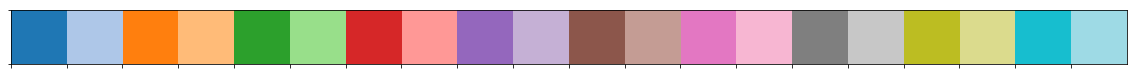

In [57]:
pal = sns.color_palette('tab20', len(top_indvs))
sns.palplot(pal)
indv_pal = {word:pal[wordi] for wordi, word in enumerate(top_indvs)}

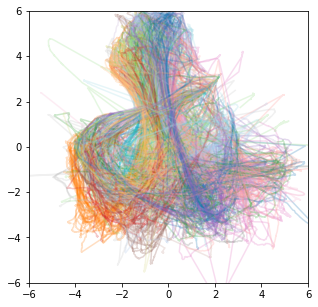

In [58]:
fig, ax = plt.subplots(figsize=(5,5))

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
    #print(indv)
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.25, color=indv_pal[indv])
ax.set_xlim(xlims);
ax.set_ylim(ylims);

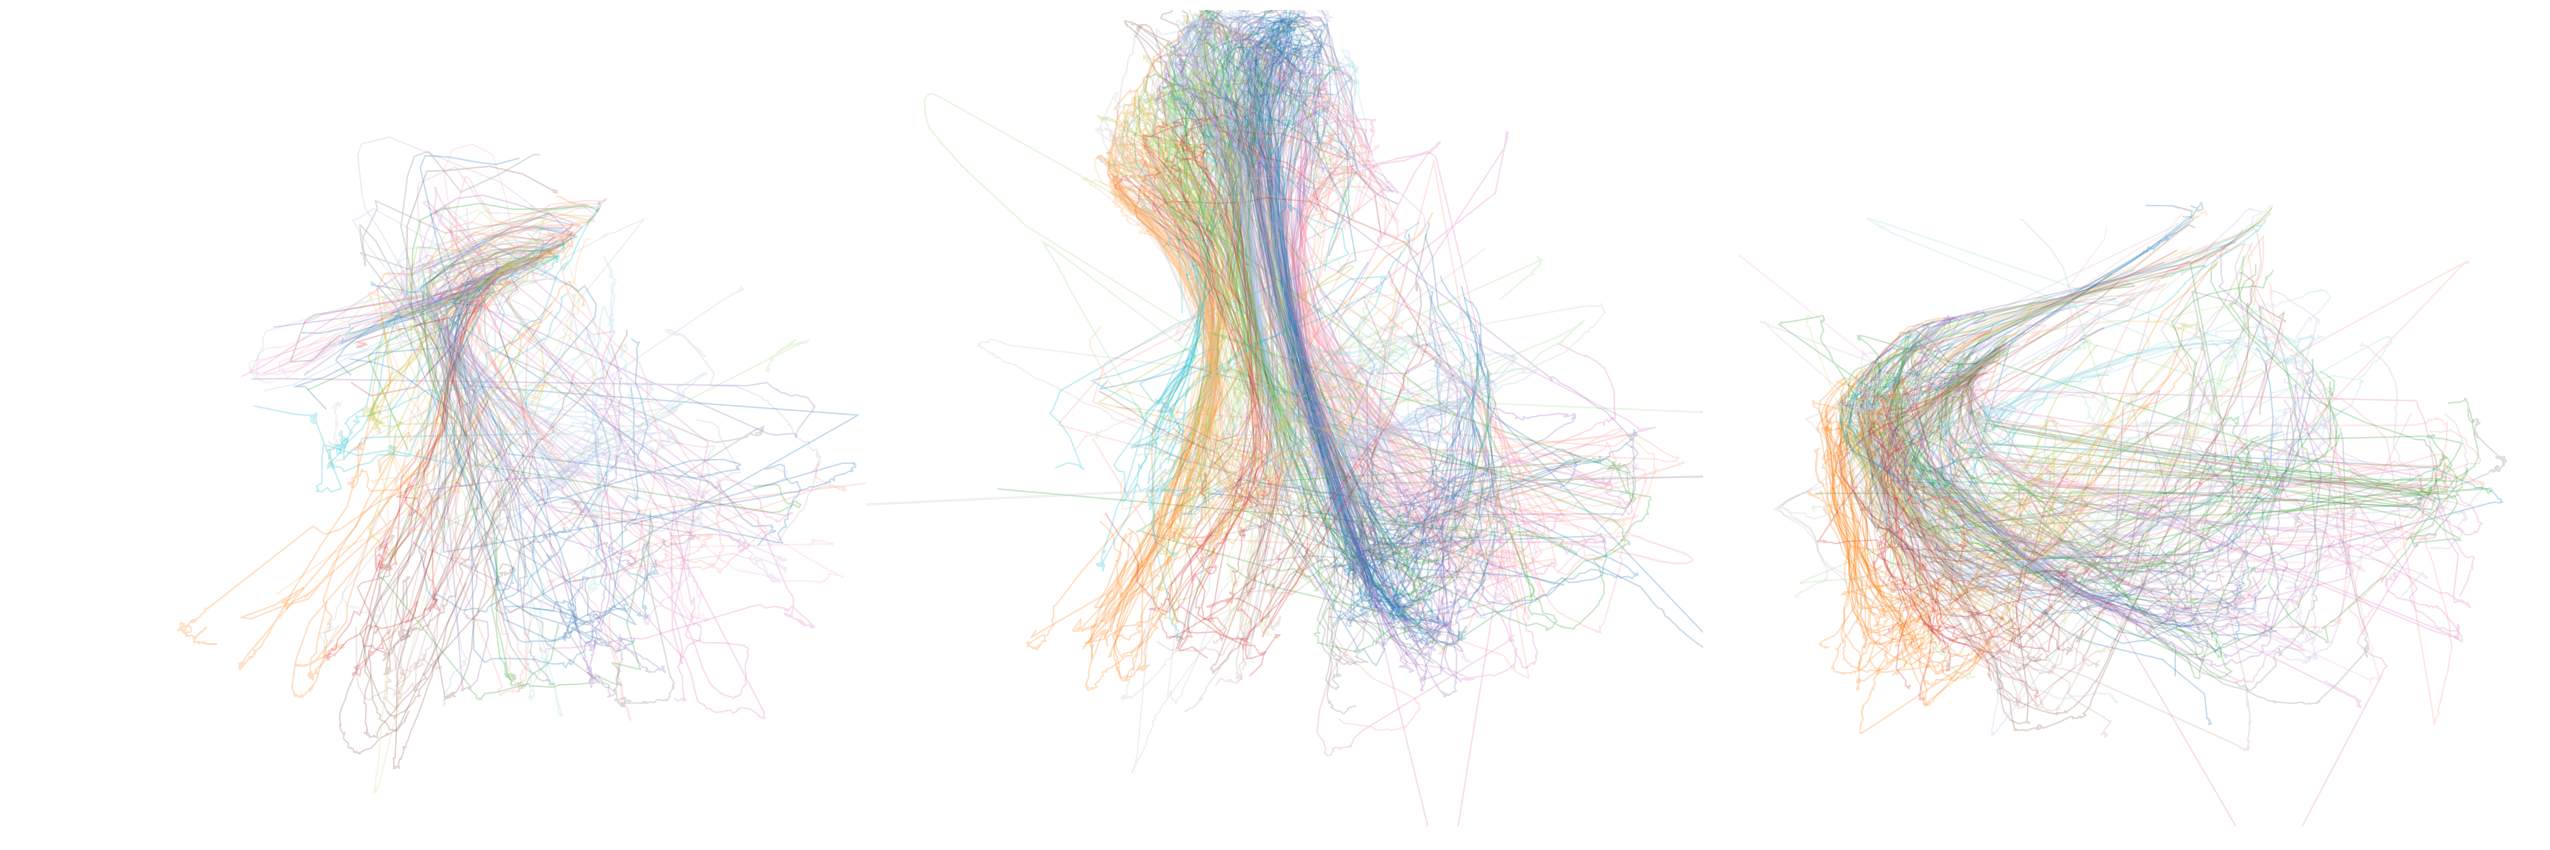

In [59]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    ax = axs.flatten()[np.where(words_df.word.values[oi] == np.unique(word_list))[0][0]]
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
    window_z = embedding[on:off, :]
    ax.plot(
        window_z[:, 0],
        window_z[:, 1],
        alpha=0.25,
        color=indv_pal[words_df.indv.values[oi]],
    )
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axis('off')
    
if savefig: save_fig(FIG_SAVE_LOC / 'indv_trajectory', save_png=True, save_svg=False)

In [60]:
#fig, ax = plt.subplots(figsize=(5,5))
indv_list = []
sex_list = []
word_list = []
word_embedding_list = []
for oi, (indv, sex, word, on, off) in enumerate(tqdm(zip(words_df.indv, words_df.sex, words_df.word, onsets, offsets), total=len(offsets))):
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
        
    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    sex_list.append(sex)
    indv_list.append(indv)
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)
sex_list = np.array(sex_list)
indv_list = np.array(indv_list)

In [61]:
from random import sample 

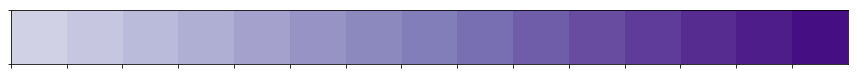

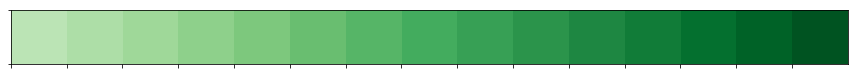

In [62]:
blue_pal = sns.color_palette('Purples', 20)[5:]
red_pal = sns.color_palette('Greens', 20)[5:]
sns.palplot(blue_pal)
sns.palplot(red_pal)

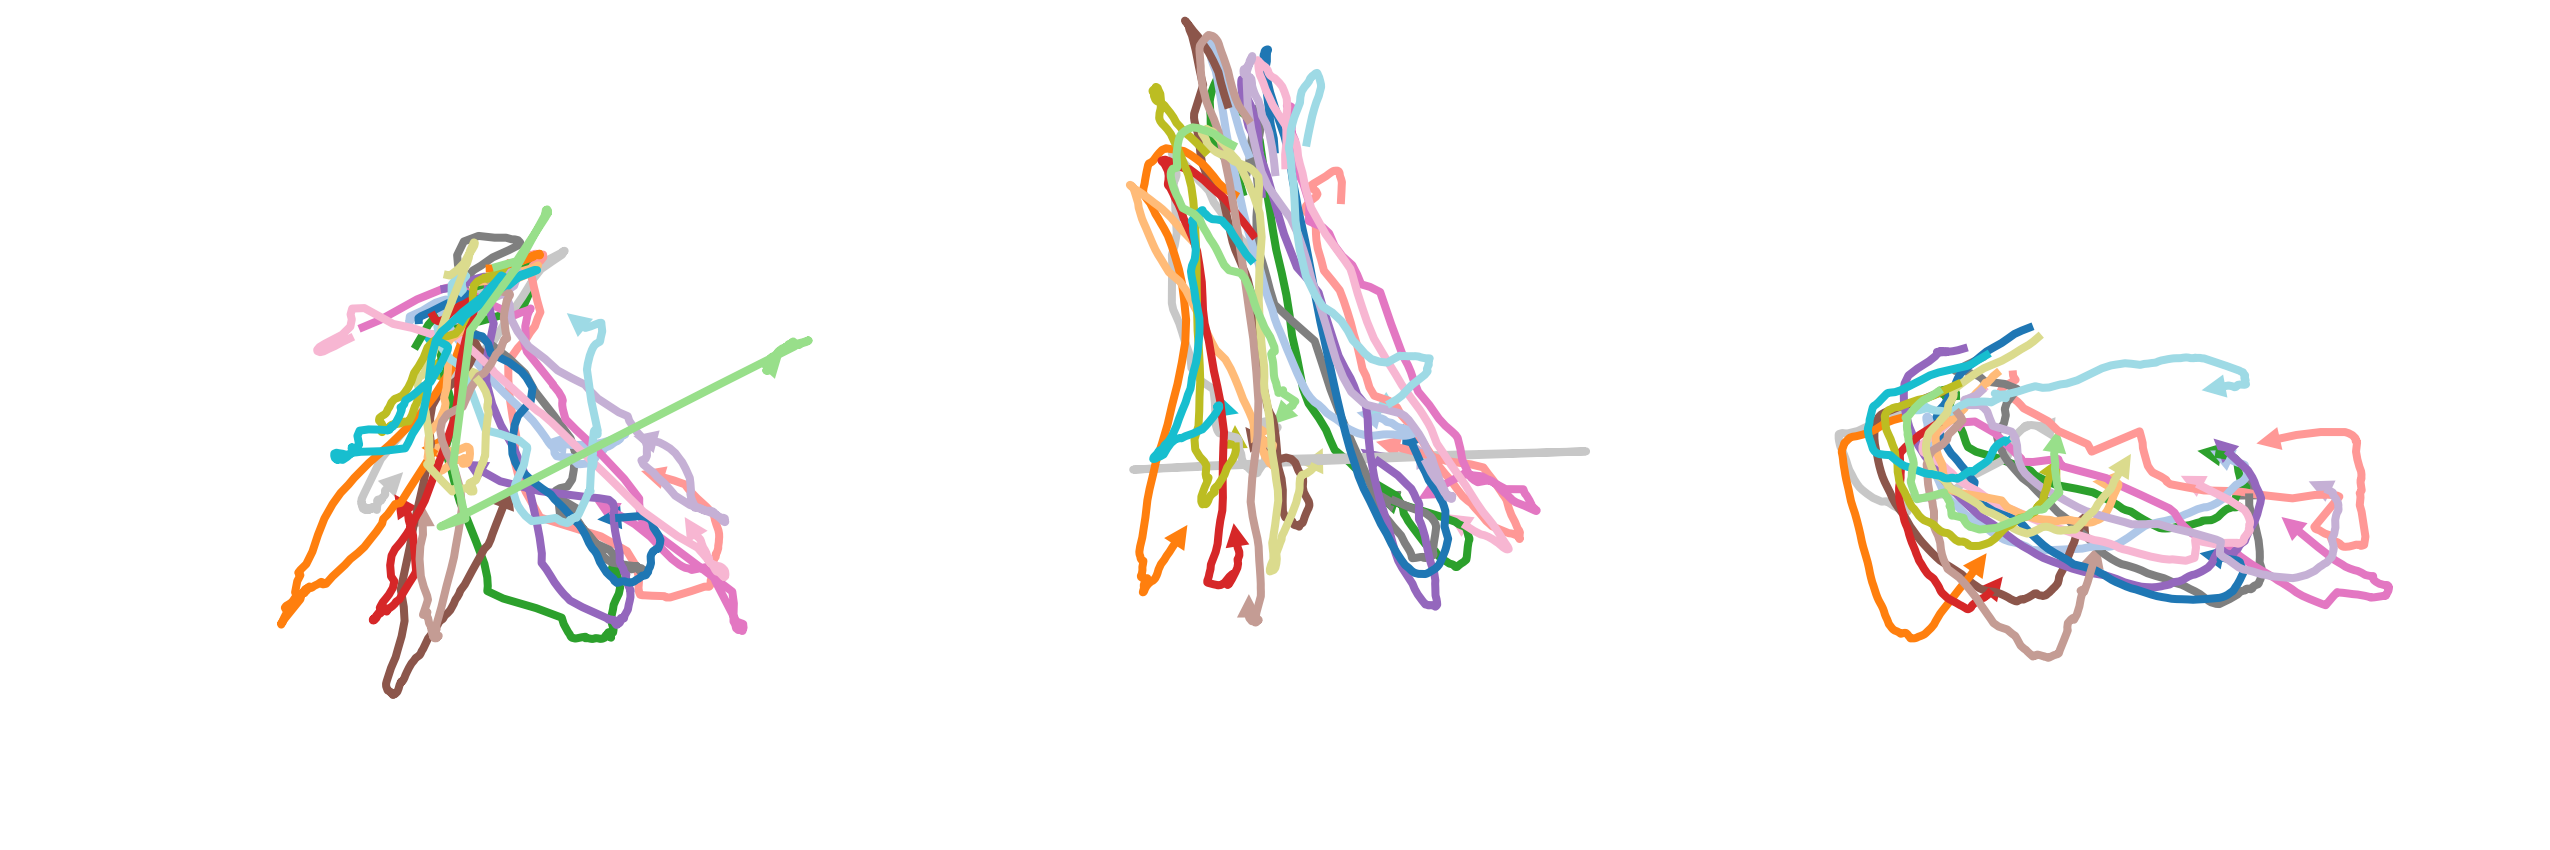

In [63]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for indv in np.unique(indv_list):
    if indv not in top_indvs:
        continue
    sex = words_df[words_df.indv == indv].sex.values[0]
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (indv_list == indv)], axis=0)
        ax = axs.flatten()[wi]
        
        if sex == 'm':
            color = sample(blue_pal, 1)[0]
        else:
            color = sample(red_pal, 1)[0]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=8,
            color=indv_pal[indv], #color, #sex_pal[sex],#indv_pal[indv],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.25,
            head_length=.25,
            linewidth=4,
            color=indv_pal[indv], #color, #sex_pal[sex],#indv_pal[indv],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'indv_vector', save_png=True, save_svg=True)

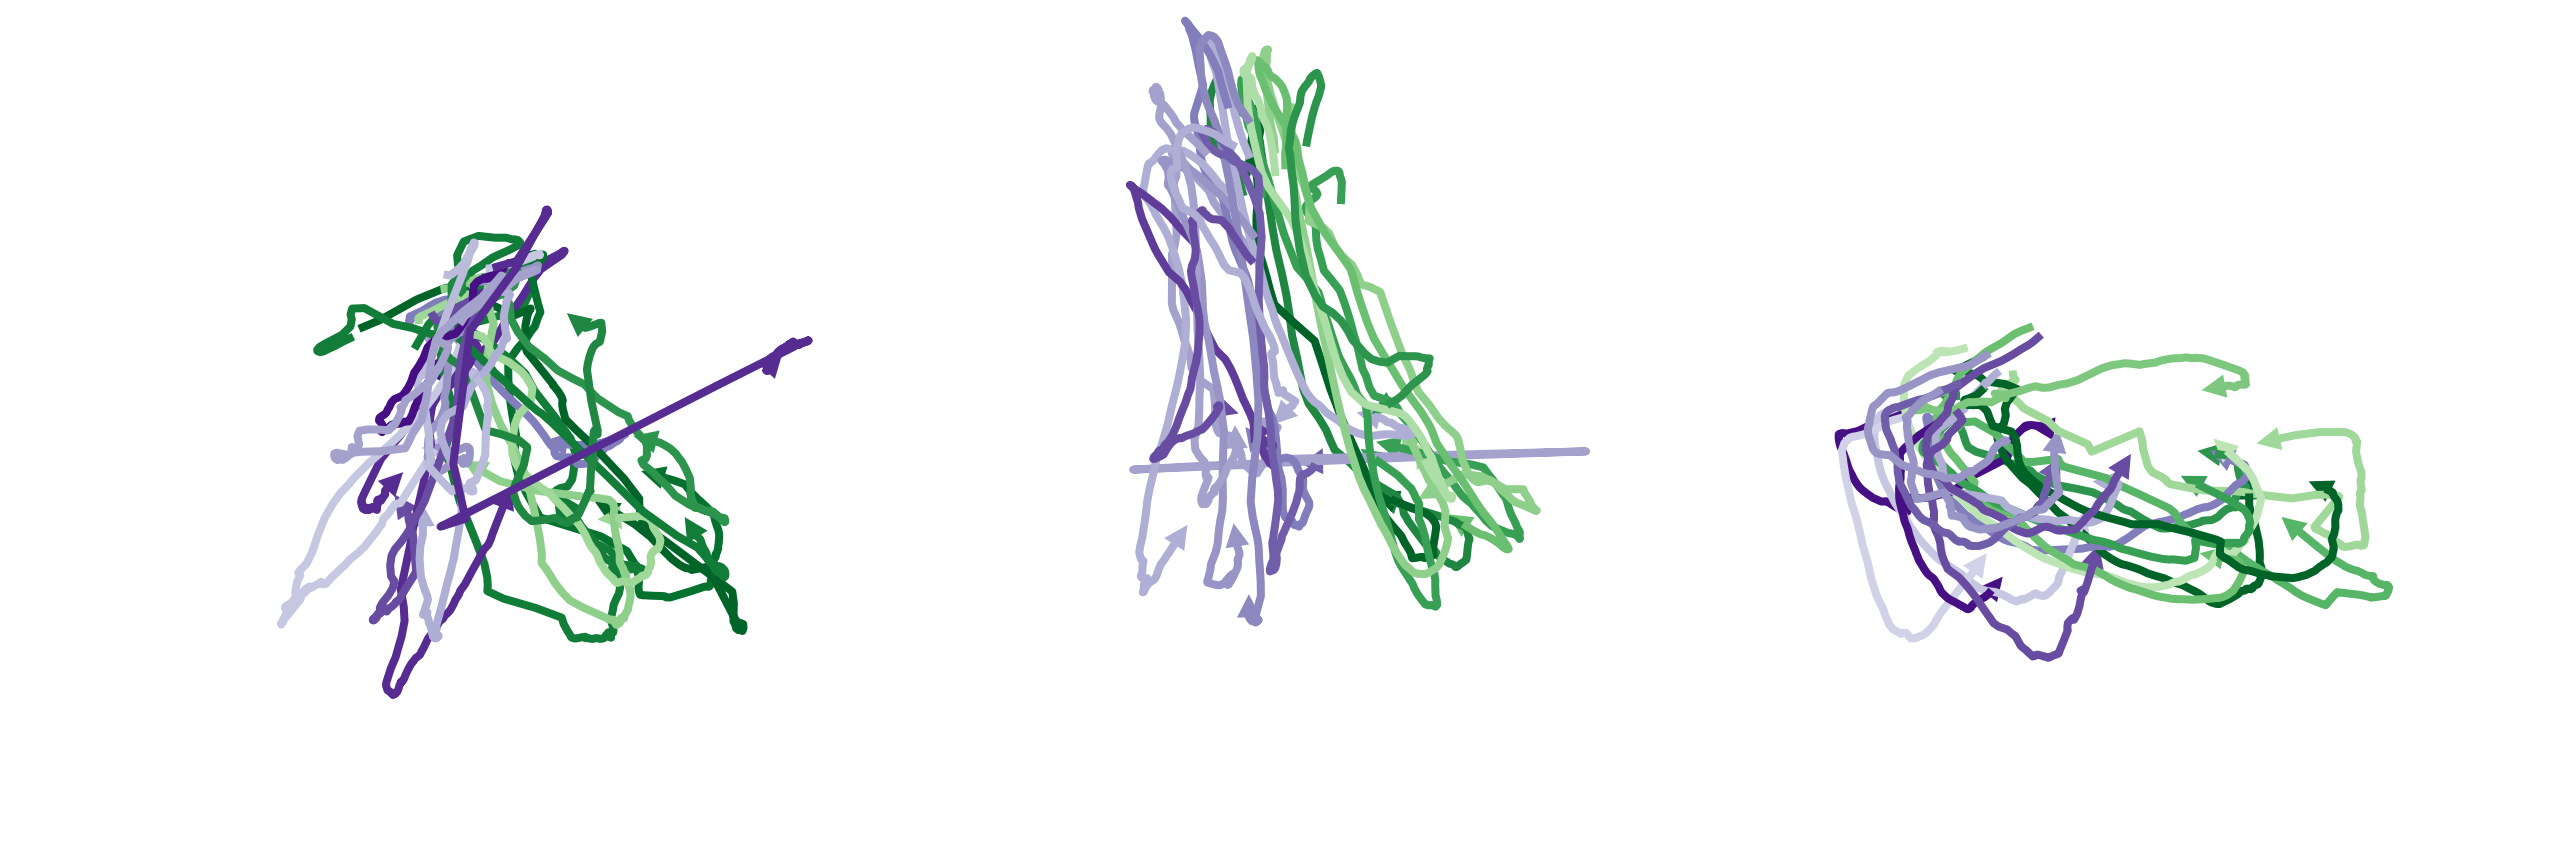

In [64]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for indv in np.unique(indv_list):
    if indv not in top_indvs:
        continue
    sex = words_df[words_df.indv == indv].sex.values[0]
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (indv_list == indv)], axis=0)
        ax = axs.flatten()[wi]
        
        if sex == 'm':
            color = sample(blue_pal, 1)[0]
        else:
            color = sample(red_pal, 1)[0]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=8,
            color=color, #sex_pal[sex],#indv_pal[indv],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.25,
            head_length=.25,
            linewidth=4,
            color=color, #sex_pal[sex],#indv_pal[indv],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'indv_sex_vector', save_png=True, save_svg=True)

### sex differences

In [65]:
words_df[:3]

start_time    end_time word   phones            phone_start_times  \
445  236.236188  236.352105  say  [s, eh]  [0.0, 0.060875000000010004]   
492  250.321120  250.586825  say  [s, ey]    [0.0, 0.1448169999999891]   
610  293.978018  294.234862  say  [s, ey]   [0.0, 0.13373199999995222]   

                                 phone_end_times  utterance_number  \
445  [0.060875000000010004, 0.11591699999999605]                74   
492    [0.1448169999999891, 0.26570499999999697]                17   
610   [0.13373199999995222, 0.25684400000000096]                22   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
445                     31           31  s25      0   o   f  s2501b  16000   
492                     10           10  s25      0   o   f  s2501b  16000   
610                      9            9  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
445  [[23, 20, 13, 10, 8, 10, 11, 14, 17, 29, 36, 4...   
492  [[10, 9, 6, 2, 0, 1, 3, 4, 3, 1, 0, 0, 0, 0, 3...   
610  [[174, 170, 157, 133, 95, 53, 30, 23, 20, 17, ...   

                                               windows  
445  [[[23, 33, 18, 28, 2, 17, 1, 0, 7, 9, 7, 3, 4,...  
492  [[[10, 2, 26, 62, 29, 6, 9, 0, 0, 0, 0, 0, 4, ...  
610  [[[174, 118, 112, 135, 116, 80, 47, 74, 76, 83...

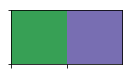

In [66]:
pal = [red_pal[8], blue_pal[8]]
sns.palplot(pal)
sex_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words_df.sex))}

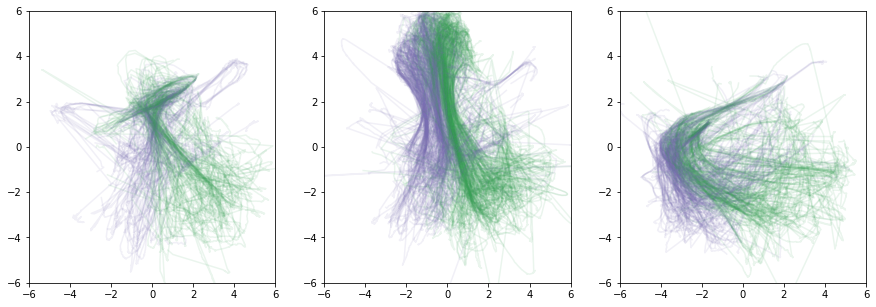

In [67]:
fig, axs = plt.subplots(ncols = len(np.unique(word_list)), figsize=(5*len(np.unique(word_list)), 5))

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    ax = axs.flatten()[np.where(words_df.word.values[oi] == np.unique(word_list))[0][0]]
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    #if oi > 1000:
    #    break
for ax in axs.flatten():
    ax.set_xlim(xlims);
    ax.set_ylim(ylims);

In [68]:
#fig, ax = plt.subplots(figsize=(5,5))
sex_list = []
word_list = []
word_embedding_list = []
for oi, (sex, word, on, off) in enumerate(tqdm(zip(words_df.sex, words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    sex_list.append(sex)
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)
sex_list = np.array(sex_list)

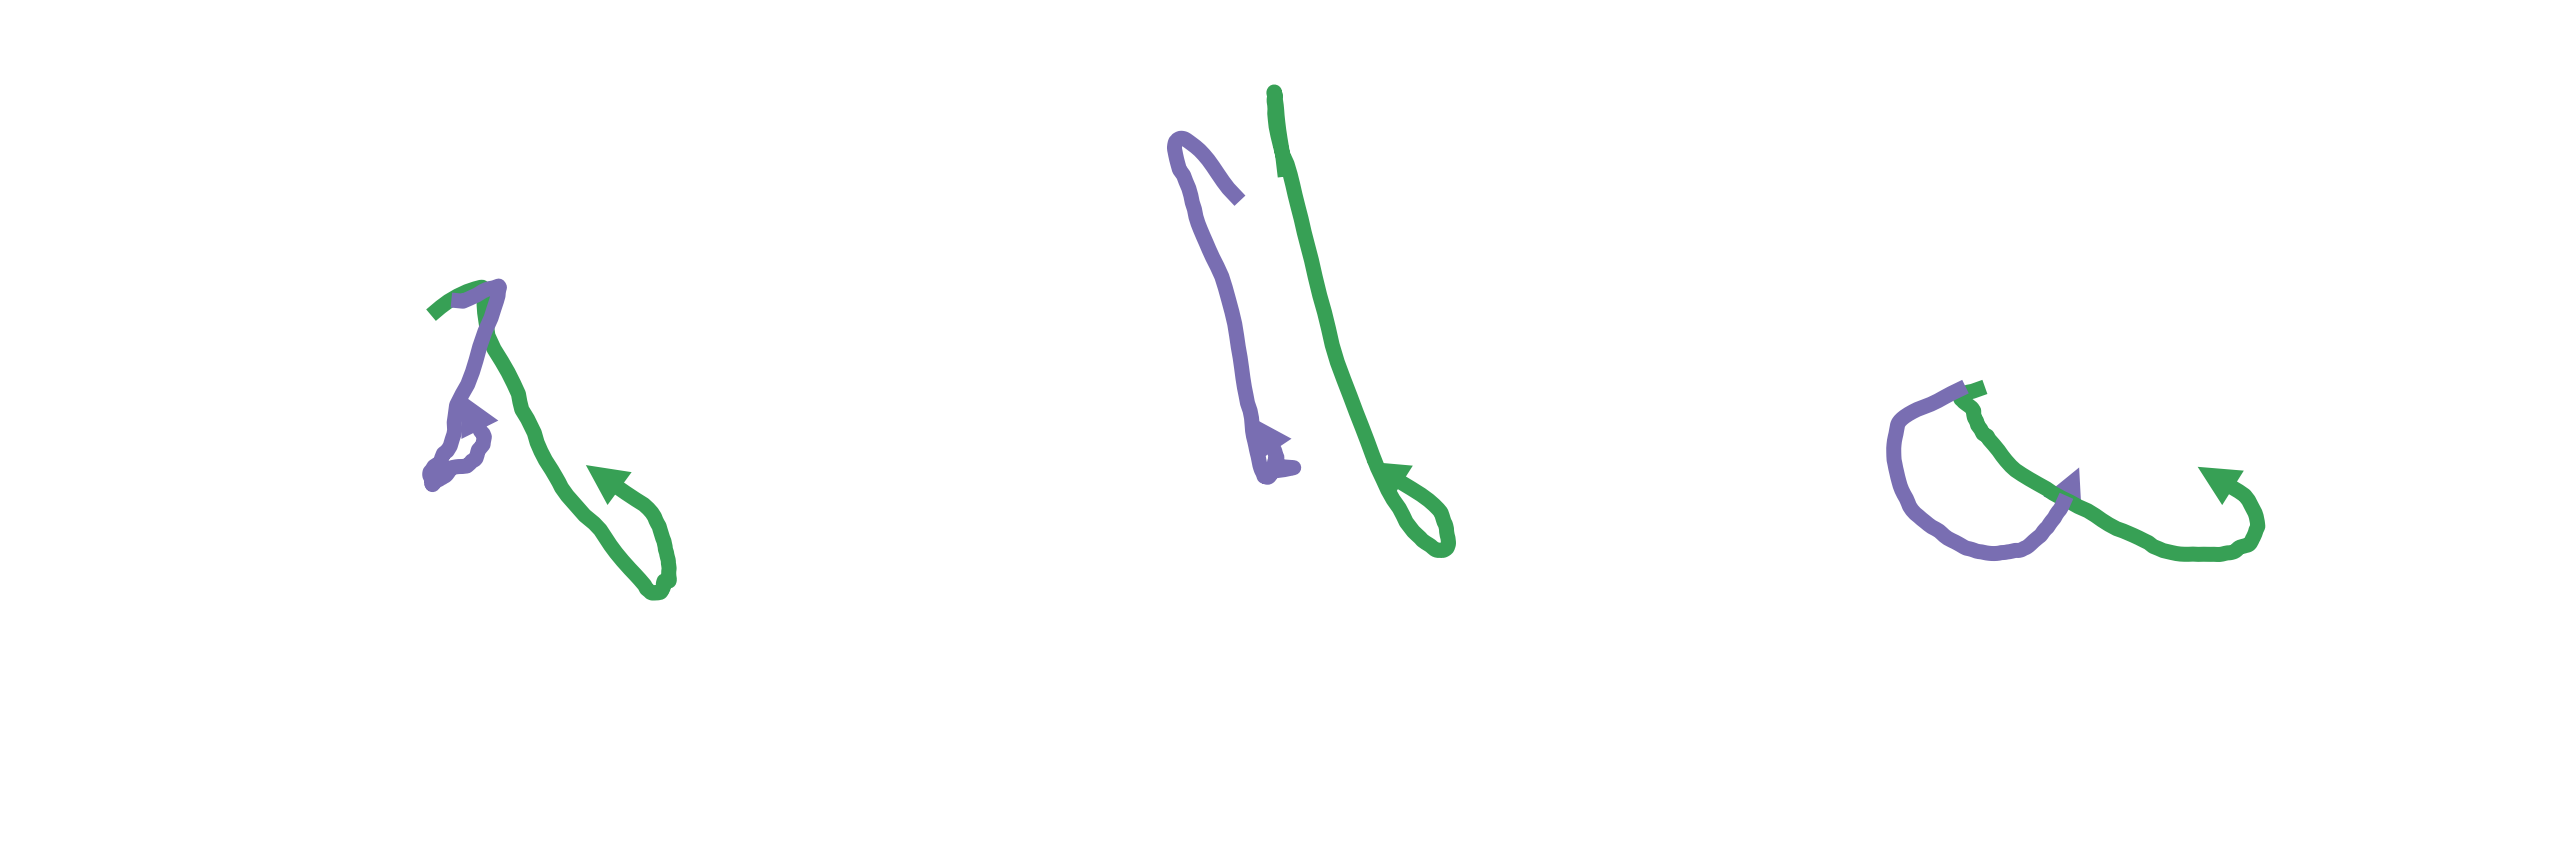

In [69]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for sex in np.unique(sex_list):
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (sex_list == sex)], axis=0)
        ax = axs.flatten()[wi]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=15,
            color=sex_pal[sex],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.5,
            head_length=.5,
            linewidth=4,
            color=sex_pal[sex],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'sex_vector', save_png=True, save_svg=True)

### spectrograms vs embeddings in colorspace

In [70]:
# plot segment labels alongside phone labels

In [71]:
import copy

In [72]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

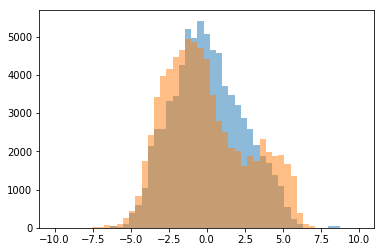

In [73]:
z_normed = copy.deepcopy(embedding)
plt.hist(z_normed[:,0], bins = np.linspace(-10,10, 50), alpha = 0.5);
plt.hist(z_normed[:,1], bins = np.linspace(-10,10, 50), alpha = 0.5);

In [74]:
xlims = [-5,5]
ylims = [-5,5]

In [75]:
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [76]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [77]:
phone_pal

{'ey': array([0.59607843, 0.30588235, 0.63921569]),
 's': array([0.21568627, 0.49411765, 0.72156863]),
 'w': array([0.30196078, 0.68627451, 0.29019608]),
 'd': array([0.89411765, 0.10196078, 0.10980392])}

In [78]:
np.shape(rgb_img)

(1, 75384, 3)

In [79]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

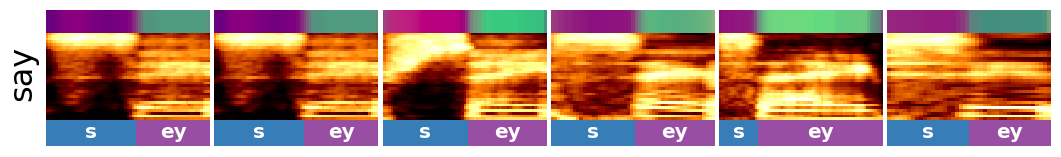

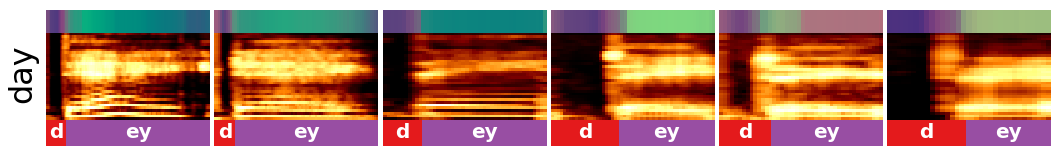

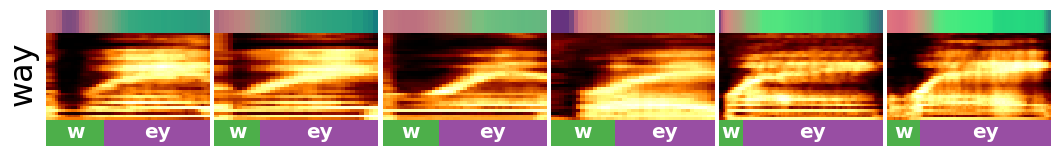

In [80]:
ncols = 6
for wi, word in enumerate(words_df.word.unique()):
    
    fig = plt.figure(figsize=((ncols)*3, 2.5)) 
    gs = gridspec.GridSpec(2, ncols, height_ratios=[1, 5]) 
    gs.update(wspace=0.025, hspace=0)
    
    for ci,col in enumerate(range(ncols)):
       
    
        row = words_df[words_df.word == word].iloc[col]
        
        while np.all([i in phone_pal for i in row.phones]) == False:
            col = col + 1
            row = words_df[words_df.word == word].iloc[col]
        
        ### plot projections
        ax = plt.subplot(gs[0, ci]) #axs[col]
        # subset embedding 
        on = onsets[np.where(words_df.index == row.name)[0][0]]
        off = offsets[np.where(words_df.index == row.name)[0][0]]

        ax.imshow(rgb_img[:,on:off, :], aspect='auto')
        
        ax.axis('off')
        ### plot spec
        ax = plt.subplot(gs[1, ci]) #axs[col]
        if ci == 0: 
            ax.set_ylabel(word, fontsize=32)
            ax.yaxis.set_label_coords(-0.05,.65)
        spec = row.spectrogram
        ax.matshow(spec, aspect='auto', origin='lower', extent = [0, row.end_time - row.start_time, 0,1], cmap = plt.cm.afmhot)
        ax.set_ylim([-.3,1])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        for phone, st, et in zip(row.phones, row.phone_start_times, row.phone_end_times):
            
            ax.add_patch(
            mpatches.Rectangle(
                [st, -.3],
                et - st,
                .3,
                ec="none",
                color=phone_pal[phone],
            )
            )
            ax.text((st + et)/2, -.2, phone, color='w', fontsize=20, horizontalalignment='center', weight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.axis('off')
    if savefig: save_fig(FIG_SAVE_LOC / ('spec_' + word), save_png=True, save_svg=True)
    plt.show()